In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from IPython.display import display, Latex


In [2]:
# Defining fixed angle values
c90, c90e, c90u = [m.pi/2,-m.pi/2], [m.pi/2,m.pi/2], [m.pi/4,m.pi/2]
c45, c45e, c45u = [0,m.pi/4], [m.pi/2,m.pi/4], [m.pi/2,3*m.pi/4]
c15, c30 =  [0,m.pi/12], [0,m.pi/6]
c15u, c30u =  [3*m.pi/4,3*m.pi/4 + m.pi/12], [3*m.pi/4,3*m.pi/4 + m.pi/6]
c7point5, c3point75 =  [0,m.pi/24], [0,m.pi/48]
c7point5u, c3point75u =  [3*m.pi/4,3*m.pi/4+m.pi/24], [3*m.pi/4,3*m.pi/4 + m.pi/48]


In [3]:
def Creating_states( coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] , Abstract = False, input_type = 'coeff'):    # coeff list like [a0,a1,b0,b1]
    if input_type == 'theta':           # Warning: angles must be in radians, order must be theta_0 and theta_1
        if len(coeff) != 2:
            print("For theta input type only two angles are to be given, in radians.")
        theta_0 = coeff[0]
        theta = coeff[1]
        coeff = [np.cos(theta_0), np.sin(theta_0), np.cos(theta_0+theta), np.sin(theta_0+theta)] # the first state here is the theta_0 angle 
        coeff = [np.round(i,9) for i in coeff]                                                   ## from |0> axis, the second theta_0 + theta
    
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])


initial_states = Creating_states(Abstract=False, coeff = [1/(2**.5),1/(2**.5),1,0])     # Creating the two states with these coefficients

psi0 = initial_states[0]
psi1 = initial_states[1]

psi0sq = []
psi1sq = []
[[psi0sq.append(i*j) for i in psi0] for j in psi0]
[[psi1sq.append(i*j) for i in psi1] for j in psi1]   # creating list of coeff for squared states (intermeditate step)

psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

# Creating theoretical Rho matrix
vec_psi0psi0 = np.array(psi0psi0)     # convertying to numpy arrays
vec_psi1psi1 = np.array(psi1psi1)

rho = (1/2)*(np.outer(vec_psi0psi0, vec_psi0psi0)+np.outer(vec_psi1psi1, vec_psi1psi1))       # density matrix with priors 1/2 each.


Original Individual code (later has pretty much everything in a compact function)

In [4]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))     # the w in the notes
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

# sum([np.trace(POVM_elts[i]) for i in range(9)])     # trace sum = 3 = Tr(Identity_(3X3)) , verified   

prob_vec_raw =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)]  #[(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec = [i.real for i in prob_vec_raw if abs(i.imag) < .01]          # cleaned up the trailing imaginary parts

# sum(prob_vec)        # sum prob = 1, verified

#Experimental part
N = 10000       # number of measurements  
POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']       # symbols to indicate collapsed direction
#prob distribution is simply the corresponding elements of the prob_vec
collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   #choosing collapse directions with weights for N trials

nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
pj_num_vec = [i/N for i in nj_vec]      
# ([i*N for i in prob_vec] , nj_vec)   # comparing the theoretical and experimental collapse probabilities, verified



# finding r vector
M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix
# np.trace(np.dot(M,M_inv))       # gives identity, checks out
r_vec = np.dot(M_inv,pj_num_vec)


#Reconstructing numerical rho
rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in notes pair_disc.pdf
rho_num = np.zeros_like(rho_num_list[0])

# Loop over the matrices and sum them element-wise to find the numerically reconstructed rho
for matrix in rho_num_list:
    rho_num = np.add(rho_num, matrix)

# print('Numerical rho:\n', rho_num) 
    
#Error Stuff   
del_rho = rho_num-rho  # defining the difference of numberical and theoretical state
# del_rho

eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
# eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue

# norm_del_rho    # "error in the density matrices" 

Pretty much everything above combined into a function for the sake of ease

In [5]:
#Creating (Experiment_Rho) function for the sake of ease, for the error in the density matrices. This plots 
def experiment_rho(N = 10000, coeff = [1,0,0,1], priors = [.5,.5], show_calcs = False, input_type = 'coeff'):
    initial_states = Creating_states( coeff = coeff, input_type= input_type)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    # psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    # psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    psi0psi0 = [psi0sq[0], (np.sqrt(2))*psi0sq[1], psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (np.sqrt(2))*psi1sq[1], psi1sq[3]]    # creating square states
    

    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec_raw =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [round(i.real, 10) for i in prob_vec_raw if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num_raw = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num_raw = np.add(rho_num_raw, matrix)       # created the numerical rho
    
    rho_num = np.real_if_close(np.around(rho_num_raw, decimals=5))
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # DEL RHO used here for \Delta \rho error. For fidelity we later change to rho_num
    # eigenvectors[:,0]   #  COLUMNs are the the corresponding eigenvector
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])    # cleaning up
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))

    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    if show_calcs == True:
        # Display states in LateX
        latex_psi0 = r'\Psi_0 = {}|0\rangle + {}|1\rangle'.format(psi0[0],psi0[1])
        latex_psi1 = r'\Psi_1 = {}|0\rangle + {}|1\rangle'.format(psi1[0],psi1[1])
        display(Latex(f'${latex_psi0}$'))
        display(Latex(f'${latex_psi1}$'))

        print(" Psi_0Psi_0 ", psi0psi0 )
        print(" Psi_1Psi_1 ", psi1psi1 )
        print(" Vec_Psi_0Psi_0 ", vec_psi0psi0)
        print(" Vec_Psi_1Psi_1 ", vec_psi1psi1)
        # Printing other parameters
        print('\n Rho_Theorectical = \n', rho)

        print('\n Prob_Theory_raw = ', prob_vec_raw)
        print('\n Prob_theory = ', prob_vec)
        print('Prob_numerical = ', pj_num_vec)

        print('Rho_Numerical_raw = \n', rho_num_raw )
        print('\n Rho_Numerical = \n', rho_num )
         
        print('\nDifference (rho-rho_num) = \n ', del_rho )
        
        print('\n evals of del_rho= \n ', evals)
        print('\n evecs of del_rho= \n ', evecs)
        
        spectral_reconstruction_DelRho = evals[0]*np.outer(evecs[:,0], evecs[:,0])+evals[1]*np.outer(evecs[:,1], evecs[:,1])+evals[2]*np.outer(evecs[:,2], evecs[:,2])  # verifying spectral decomposition, and that indeed the columns r the evecs
        print('Spectra_reconstruction = \n',spectral_reconstruction_DelRho)
        
        print('\n largest mod eval (error) =' , error)
    return [error, rho, rho_num, evals, evecs]

# experiment_rho(10000, [1,0,0,1],[.5,.5], True)     # Example. prints intermediate quantites for analysis.
# experiment_rho(N=100000, coeff = [m.pi/2, m.pi/4], priors = [.5,.5], show_calcs = True, input_type='theta')[1:]



# defining solving the quadratic equation fn
def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-np.sqrt(d))/(2*a)
    sol2 = (-b+np.sqrt(d))/(2*a)
    return [sol1, sol2]

In [6]:
# Fidelity Function
def fid( N = 1000,c = [1,0,0,1], p = [.5,.5], threshold = .05, analysis = False, input_type = 'coeff'):
    experiment = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False, input_type= input_type)
    # rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]      # previous ones.
    # rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    rho = experiment[1]
    rho_expt = experiment[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])  # !!! does this rounding affect things later..?
    # evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    evecs = np.around(eigenvectors, decimals=9)
    min_eval = np.min([abs(i) for i in evals])
    
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector 
    c00,c01,c11 = xi[0],xi[1],xi[2]                         #...corresponding to the minimum eval

    # xi = [0,.577, -.8164]     # xi vector is same as the vector 
    # c00,c01,c11 = xi[0],xi[1],xi[2]                         #...corresponding to the minimum eval
    
    if input_type == 'theta':       # creating explicit coeff list If angle list is given as input
        states_list = Creating_states(coeff=c, input_type='theta')
        c = states_list[0]+ states_list[1]

    threshold = 4.3/(N**.5)           # dynamic threshold, comment out to remove

    c_raw = 0

    if abs(c00) > threshold and abs(c11) > threshold: 
        # print("condition 1")              
        if abs(c11)/abs(c00) < 2:
            soln  =  solve_quadratic(c00, np.sqrt(2)*c01, c11)
            # soln  =  solve_quadratic(c00, 2*c01, c11)
            z_a,z_b = soln[0], soln[1]
            a1 = (1/(np.sqrt(1+abs(z_a)**2)))           
            a0 = np.conj(z_a)*a1
            b1 = (1/(np.sqrt(1+abs(z_b)**2)))
            b0 = np.conj(z_b)*b1
            c_raw = [a0,a1,b0,b1]
            # print(z_a,z_b)
            # print('coeffs',a0,a1,b0,b1)
        else:
            soln  =  solve_quadratic(c11, np.sqrt(2)*c01, c00)
            # soln  =  solve_quadratic(c11, 2*c01, c00)
            z_a,z_b = soln[0], soln[1]
            a0 = (1/(np.sqrt(1+abs(z_a)**2)))                          
            a1 = np.conj(z_a)*a0
            b0 = (1/(np.sqrt(1+abs(z_b)**2)))
            b1 = np.conj(z_b)*b0
            c_raw = [a0,a1,b0,b1]
            # print(z_a,z_b)
            # print('coeffs',a0,a1,b0,b1)
        
    elif abs(c00) <= threshold and abs(c11) > threshold:      # some cases are excluded if we don't use eqality
        a0, a1 = 1,0        # random choice, matching later
        # z = np.conj((-c11)/(2*c01))     # z defined as (a0*/a1*)
        z = np.conj((-c11)/(np.sqrt(2)*c01))     # z defined as (a0*/a1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        # print('condition #2')
        c_raw = [a0,a1,b0,b1]
    elif abs(c00) > threshold and abs(c11) <= threshold:
        a0, a1 = 0,1        
        # z = np.conj((-2*c01)/(c00))      # z defined as (b0*/b1*)
        z = np.conj((-(np.sqrt(2))*c01)/(c00))      # z defined as (b0*/b1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        # print('condition #3, z = ',z)
        c_raw = [a0,a1,b0,b1]
    elif abs(c00) <= threshold and abs(c11) <= threshold:
        a0, a1 = 0,1        
        b0, b1 = 1,0     
        c_raw = [a0,a1,b0,b1]
        # print('condition #4')

    # print('c raw = ', c_raw)
    # print('type c raw = ', type(c_raw))
    
    # c_raw = [a0,a1,b0,b1]
    # c_raw = [np.round(i,6) for i in c_raw]
    # c_raw = [np.round(, 6), np.round(a1, 6), np.round(b0, 6), np.round(b1, 6)]
        
    # fidelity as measure
    f00 = (abs((c_raw[0]*c[0]+c_raw[1]*c[1])))**2
    f01 = (abs((c_raw[0]*c[2]+c_raw[1]*c[3])))**2
    f10 = (abs((c_raw[2]*c[0]+c_raw[3]*c[1])))**2
    f11 = (abs((c_raw[2]*c[2]+c_raw[3]*c[3])))**2

    if  (f00 + f11) > (f01+ f10) :       # sum of angle is bad for mis-assigned vecs
        c_num = c_raw
    else:
        c_num = [c_raw[2],c_raw[3],c_raw[0],c_raw[1]]

    F_a = (abs(sum([np.conj(c[i])*c_num[i] for i in range(0,2)])))**2
    F_b = (abs(sum([np.conj(c[i])*c_num[i] for i in range(2,4)])))**2
    if analysis == True:
        dyn_thresh_max = max([abs(c00),abs(c11)])
        dyn_thresh_min = min([abs(c00),abs(c11)])
        # print('\n')

        print('thresholds max min~', [dyn_thresh_max, dyn_thresh_min])
        print('used_threshold ~',threshold)
        
        print('\n')
        print('\n')
        print("Rho =", rho )
        print("Rho_num =", rho_expt )
        print('\n')
        # print("Original Eval =", eigenvalues)
        print("Eval =", evals)
        print('\n')
        print("Original Evecs =", eigenvectors)
        print('\n')
        print("Evec =", evecs)
        print('\n')
        print('xi=', xi)
        print('\n')

        spectral_recons_rho_expt = evals[0]*np.outer(evecs[:,0], evecs[:,0])+evals[1]*np.outer(evecs[:,1], evecs[:,1])+evals[2]*np.outer(evecs[:,2], evecs[:,2]) 
        print("Sprectra Reconstruction", spectral_recons_rho_expt)


        print('\n')
        print('\n')
        print('c raw = ', np.round(c_raw,3))
        print('Numeriacl', np.round(c_num,3))
        print('Theoretical', np.round(c,3)) 
        print('\n')

        # print('metric fids = ', [f00,f01], [f10,f11])
        print('\n')
        print('Fidelity', [F_a,F_b])
    else:
        return [[xi], '', c , c_num, [F_a,F_b]]

# fid(c=[1,0,0,1], N = 1000, p=[.7,.3])       # Example. Returns list [xi, '', input states, reconstructed states, fidelitties]       
# fid(c=[m.pi/4, m.pi/2], N = 1000, analysis=True, input_type= 'theta') #Example. Returns analysis - first inputs state is (1,1) second is (-1,1).

In [7]:
# RoughPad for Trials
# fid(c=[1,0,0,1], N = 1000, p=[.7,.3], analysis=True)  
# fid(c=c90, N =10000, analysis=True, input_type='theta')

fid(c=[1,0,0,1], N =50000, analysis=True)

thresholds max min~ [0.006711096854353988, 0.005796927234712628]
used_threshold ~ 0.01923018460649819




Rho = [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.5]]
Rho_num = [[ 5.0272e-01+0.j      -2.3400e-03+0.0017j  -3.2000e-04+0.00319j]
 [-2.3400e-03-0.0017j   2.0000e-03-0.j       1.0800e-03+0.00312j]
 [-3.2000e-04-0.00319j  1.0800e-03-0.00312j  4.9528e-01+0.j     ]]


Eval = [0.50392215 0.49411677 0.00196107]


Original Evecs = [[ 9.37595587e-01+0.j          3.65357962e-02-0.34575431j
   4.71180821e-03-0.00337687j]
 [-2.30031781e-03-0.00414653j  6.89499248e-04+0.00746208j
   9.99960678e-01+0.j        ]
 [-3.65015717e-02-0.34577401j  9.37583560e-01+0.j
  -2.16427445e-03+0.00635254j]]


Evec = [[ 9.37595587e-01+0.j          3.65357960e-02-0.34575431j
   4.71180800e-03-0.00337687j]
 [-2.30031800e-03-0.00414653j  6.89499000e-04+0.00746208j
   9.99960678e-01+0.j        ]
 [-3.65015720e-02-0.34577401j  9.37583560e-01+0.j
  -2.16427400e-03+0.00635254j]]


xi= [ 0.00471181-0.00337687j  0.9999606

In [8]:
# BACKUP Plotting function for both quantities

# def Plotting(N = 10000, c = [1,0,0,1], p = [.5,.5], step = 100, metric = 'f', size = [3,3], k = 10, starting_step = 10, input_type = 'coeff'):        # function to plot error vs trials plot. N,c,p are Number of trials, coefficients and priors
    
#     if input_type == 'theta':           # Warning: angles must be in radians, order must be theta_0 and theta_1
#         if len(c) != 2:
#             print("For theta input type only two angles are to be given, in radians.")
#         theta_0 = c[0]
#         theta = c[1]
#         c = [np.cos(theta_0), np.sin(theta_0), np.cos(theta_0+theta), np.sin(theta_0+theta)] # the first state here is the theta_0 angle 
#         c = [np.round(i,9) for i in c]                                                   ## from |0> axis, the second theta_0 + theta
#     print("Input state coefficients =", c)
    
#     count = N//step
#     # trials_list = [step*(i+1) for i in range(count)] 
#     trials_list = [step*(i) for i in range(1,count+1)]    # only works if N is a multiple of 100
#     sqrtN = [k/((i)**.5) for i in trials_list]    # ideal curve, k is steepness
#     sqrt_fid = [(1-1/(np.sqrt(k*i))) for i in trials_list]   # Ideal Sq root Curve for Fidelity
#     # sqrt_fid = [(1-1/((k*i))) for i in trials_list]   #  1/N curve
    
#     errors_list_0 = [] 
#     errors_list_1 = []
#     convergance = ''
    
#     if metric == 'f':
#         label_0 = r' Fidelity $| \Psi_0 \rangle $'
#         label_1 = r' Fidelity $| \Psi_1\rangle$'
#         errors_list_0 = [fid(i,c,p)[-1][0] for i in trials_list]
#         errors_list_1 = [fid(i,c,p)[-1][1] for i in trials_list]
#         lasts_0 = errors_list_0[len(errors_list_0)*99//100:]
#         lasts_1 = errors_list_1[len(errors_list_1)*99//100:]
#         # convergance = f'Fidelity Coverged to:  , {()}'
#     else: 
#         label_0 = r'$\Delta \rho$'
#         errors_list_0 = [experiment_rho(i, c , p)[0] for i in trials_list]
#         lasts_0 = errors_list_0[len(errors_list_0)*99//100:]
#         # convergance = f'Error Coverged to:  , {errors_list_0[-1]}'

#     plt.figure(figsize=(size[0],size[1]))
#     plt.ylabel(r'$|\Delta \rho|$')

#     plt.plot(trials_list[starting_step:], errors_list_0[starting_step:], label=label_0)         # skipping plotting the first five entries coz of errors
#     if metric=='f':
#         # plt.plot(trials_list[2:], errors_list_1[2:], label=label_1, color = 'orange')
#         plt.plot(trials_list[starting_step:], errors_list_1[starting_step:], label=label_1, color = 'orange')
#         plt.ylabel('Fidelity')
#         # plt.plot(trials_list[3:],sqrt_fid[3:], "--", label=r'$(1-\frac{1}{\sqrt{kN}})$;'+f" k = {k}", color = 'black')    # sqrt N error qualitatively
#         if k != 0:                                                                                  # put k=0 if the ideal curve is not needed
#             plt.plot(trials_list[starting_step//2:],sqrt_fid[starting_step//2:], "--", label=r'$(1-\frac{1}{\sqrt{kN}})$;'+f" k = {k}", color = 'black')    # sqrt N error qualitatively
#         convergance=[np.round((sum(lasts_0)/len(lasts_0)),5), np.round((sum(lasts_1)/len(lasts_1)),5)]  # average convergances
#     else:
#         # plt.plot(trials_list[5:],sqrtN[5:], "--", label= r'$\frac{1}{\sqrt{kN}}$;'+f" k = {k}")
#         plt.plot(trials_list[starting_step//2:],sqrtN[starting_step//2:], "--", label= r'$\frac{1}{\sqrt{kN}}$;'+f" k = {k}")
#         convergance=[np.round((sum(lasts_0)/len(lasts_0)),7)]  # average convergances
    
#     plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $\eta_1={},\,\eta_2={}$'.format(round(c[0],3), round(c[1],3), round(c[2],3), round(c[3],3), p[0], p[1]))
#     plt.xlabel(f' Trials. Fidelities/Error Converges to {convergance} ')
#     plt.legend()
#     plt.show()



In [9]:
# Plotting function for both quantities

def Plotting(N = 10000, c = [1,0,0,1], p = [.5,.5], step = 100, metric = 'f', size = [3,3], k = 10, starting_step = 10, input_type = 'coeff'):        # function to plot error vs trials plot. N,c,p are Number of trials, coefficients and priors
    
    if input_type == 'theta':           # Warning: angles must be in radians, order must be theta_0 and theta_1
        if len(c) != 2:
            print("For theta input type only two angles are to be given, in radians.")
        theta_0 = c[0]
        theta = c[1]
        c = [np.cos(theta_0), np.sin(theta_0), np.cos(theta_0+theta), np.sin(theta_0+theta)] # the first state here is the theta_0 angle 
        c = [np.round(i,9) for i in c]                                                   ## from |0> axis, the second theta_0 + theta
    print("Input state coefficients =", c)
    
    if type(k) == int or type(k) == float:
        k = [k,k]
    elif len(k) > 2:
        print("Error: k has to be two numbers")

    count = N//step
    # trials_list = [step*(i+1) for i in range(count)] 
    trials_list = [step*(i) for i in range(1,count+1)]    # only works if N is a multiple of 100
    sqrtN = [k[0]/((i)**.5) for i in trials_list]    # ideal curve, k is steepness
    # sqrt_fid = [(1-1/((k*i))) for i in trials_list]   #  1/N curve
    
    inv_sqrt_curve0 = [(1-1/(np.sqrt(k[0]*i))) for i in trials_list]   # Ideal Sq root Curve for Fidelity
    inv_sqrt_curve1 = [(1-1/(np.sqrt(k[1]*i))) for i in trials_list]   # Ideal Sq root Curve for Fidelity


    errors_list_0 = [] 
    errors_list_1 = []
    convergance = ''
    
    if metric == 'f':
        label_0 = r' Fidelity $| \Psi_0 \rangle $'
        label_1 = r' Fidelity $| \Psi_1\rangle$'
        errors_list_0 = [fid(i,c,p)[-1][0] for i in trials_list]
        errors_list_1 = [fid(i,c,p)[-1][1] for i in trials_list]
        lasts_0 = errors_list_0[len(errors_list_0)*99//100:]
        lasts_1 = errors_list_1[len(errors_list_1)*99//100:]
        # convergance = f'Fidelity Coverged to:  , {()}'
    else: 
        label_0 = r'$\Delta \rho$'
        errors_list_0 = [experiment_rho(i, c , p)[0] for i in trials_list]
        lasts_0 = errors_list_0[len(errors_list_0)*99//100:]
        # convergance = f'Error Coverged to:  , {errors_list_0[-1]}'

    plt.figure(figsize=(size[0],size[1]))
    plt.ylabel(r'$|\Delta \rho|$')
    # convergance = 0
    
    # plt.plot(trials_list[starting_step:], errors_list_0[starting_step:], label=label_0)         # skipping plotting the first five entries coz of errors
    if metric=='f':
        plt.subplot(1,2,1)
        plt.plot(trials_list[starting_step:], errors_list_0[starting_step:], label=label_0)         # skipping plotting the first five entries coz of errors
        if k[0] != 0:                                                                                  # put k=0 if the ideal curve is not needed
            plt.plot(trials_list[starting_step//2:],inv_sqrt_curve0[starting_step//2:], "--", label=r'$(1-\frac{1}{\sqrt{kN}})$; $k_0 =$ '+f"{k[0]}", color = 'black')    # sqrt N error qualitatively
        plt.ylabel('Fidelity')
        # plt.xlabel(f' Trials ')
        plt.title(r'|$\Psi_0\rangle = \ {}|0\rangle + {}|1\rangle$ '.format(round(c[0],3), round(c[1],3)))
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(trials_list[starting_step:], errors_list_1[starting_step:], label=label_1, color = 'orange')
        if k != 0:                                                                                  # put k=0 if the ideal curve is not needed
            plt.plot(trials_list[starting_step//2:],inv_sqrt_curve1[starting_step//2:], "--", label=r'$(1-\frac{1}{\sqrt{kN}})$; $k_1 =$ '+f"{k[1]}", color = 'black')    # sqrt N error qualitatively
        # plt.xlabel(f' Trials ')
        plt.title(r'|$\Psi_1\rangle = \ {}|0\rangle + {}|1\rangle$ '.format(round(c[2],3), round(c[3],3)))
        
        convergance=[np.round((sum(lasts_0)/len(lasts_0)),5), np.round((sum(lasts_1)/len(lasts_1)),5)]  # average convergances
        plt.legend()
        
        # plt.tight_layout()
    else:
        plt.plot(trials_list[starting_step:], errors_list_0[starting_step:], label=label_0)         # skipping plotting the first five entries coz of errors
        plt.plot(trials_list[starting_step//2:],sqrtN[starting_step//2:], "--", label= r'$\frac{1}{\sqrt{kN}}$;'+f" k = {k}")
        convergance=[np.round((sum(lasts_0)/len(lasts_0)),7)]  # average convergances
    
    plt.suptitle(r' Reconstructed Quantum States $|\Psi_0\rangle$ & $|\Psi_1\rangle$ with priors $\eta_i$ = ({}, {}) respecitvely '.format(p[0], p[1]))       # title of the entire plot
    # plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $\eta_1={},\,\eta_2={}$'.format(round(c[0],3), round(c[1],3), round(c[2],3), round(c[3],3), p[0], p[1]))
    plt.figtext(0.5, 0.01, f"Average converagance of last 1% values at {convergance} respectively", ha='center', va='bottom') # subcaption at the bottom
    plt.show()



In [10]:
#Histogram analysis etc
t = 100     #number of experiments with N trials to find the histogram
# plt.hist([fid(c=c45, N = 1000)[-1][0] for i in range(1000)],bins = 100)  # thousand expt of N trials each
plt.hist([fid(c=c90, N = 100)[-1][0] for i in range(t)],bins = 100)  # thousand expt of N trials each
# c=c90, N=10000,  step= 2, size=[8,8], k =15, starting_step= 250
plt.title(f"Fidelity Distribution over {t} experiments")
plt.xlabel("Fidelity")
plt.xlabel("Frequency")

# taking a look at the outlier fidelities.
outties = [i for i in [fid(N=100)[-1][0] for j in range(t)] if i < .995]
print(outties)
print('outties=', len(outties), 'out of ', t )

IndexError: list index out of range

In [ ]:
# fluctuations scaling check

"""N = 2500
c = [.707,.707,1,0]
# threshs = [fid(i, c)[0] for i in range(N)[10:]] #max./
threshs = [fid(i, c)[1] for i in range(N)[10:]] #min
plt.plot(range(N)[10:], threshs)
lasts = threshs[99*N//100:]
average_thresh = (sum(lasts)/len(lasts))
print(lasts[-1:-5:-1])
print(average_thresh)"""

'N = 2500\nc = [.707,.707,1,0]\n# threshs = [fid(i, c)[0] for i in range(N)[10:]] #max./\nthreshs = [fid(i, c)[1] for i in range(N)[10:]] #min\nplt.plot(range(N)[10:], threshs)\nlasts = threshs[99*N//100:]\naverage_thresh = (sum(lasts)/len(lasts))\nprint(lasts[-1:-5:-1])\nprint(average_thresh)'

In [ ]:
# fluctuations scaling check too
# # print(lasts[50:80])
# # print(sum([1 for i in lasts if i>.05]))

# print('unit=',1/(N)**.5)
# print(len(lasts))
# print(sum([1 for i in lasts if i>5*.02]))
# print(sum([1 for i in lasts if i>2.5*.02]))
# print(sum([1 for i in lasts if i<2.5*.02]))
# print(sum([1 for i in lasts if i<1*.02]))

Input state coefficients = [0.951056516, 0.309016994, 0.629320391, 0.777145961]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_12165/3238703285.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  inv_sqrt_curve0 = [(1-1/(np.sqrt(k[0]*i))) for i in trials_list]   # Ideal Sq root Curve for Fidelity
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_12165/3238703285.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  inv_sqrt_curve1 = [(1-1/(np.sqrt(k[1]*i))) for i in trials_list]   # Ideal Sq root Curve for Fidelity
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_12165/3238703285.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


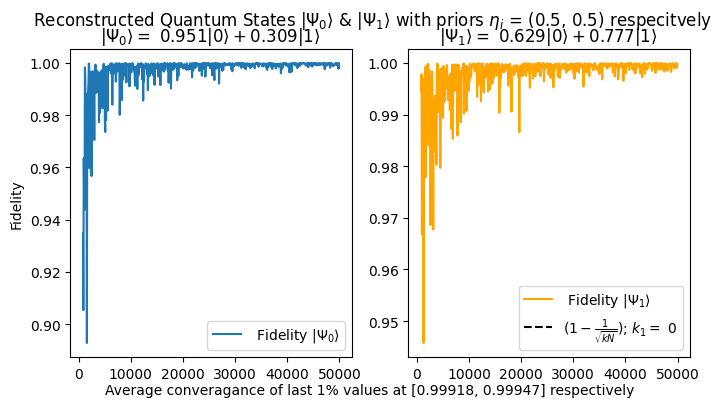

In [11]:
# 15 degrees

# Plotting(c= c15,  N=10000 ,  step= 50, size=[5,5],  k = 1/50,  starting_step= 5, input_type = 'theta')
Plotting(c= [m.pi/10, m.pi/10+m.pi/12],  N=50000,  step= 75, size=[8,4], k = 0,  starting_step= 10, input_type = 'theta')
# Plotting(c= c15u,  N=100000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')

Input state coefficients = [1.0, 0.0, 0.991444861, 0.130526192]


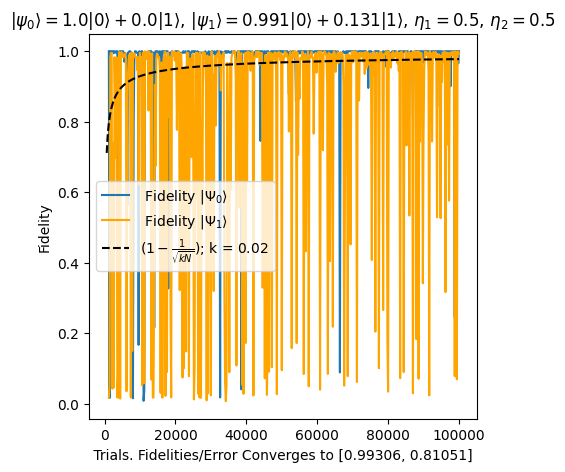

Input state coefficients = [-0.707106781, 0.707106781, 0.130526192, -0.991444861]


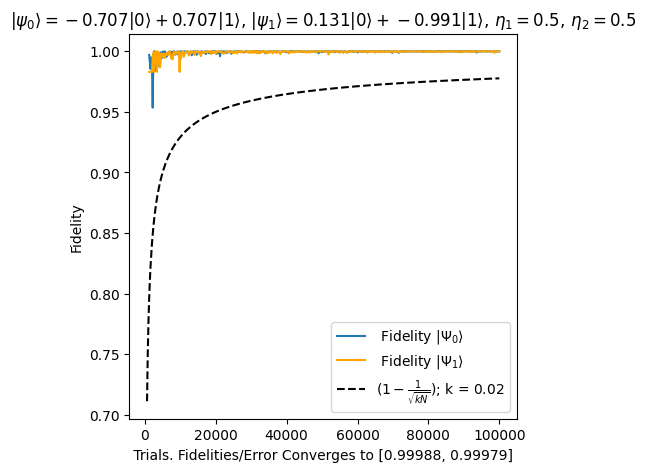

In [ ]:
# 7.5 degrees
Plotting(c= c7point5 ,  N=100000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')
Plotting(c= c7point5u,  N=100000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')

Input state coefficients = [1.0, 0.0, 0.997858923, 0.065403129]


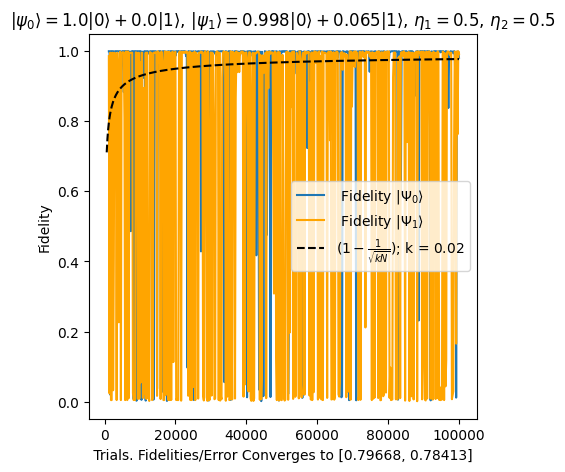

Input state coefficients = [-0.707106781, 0.707106781, 0.065403129, -0.997858923]


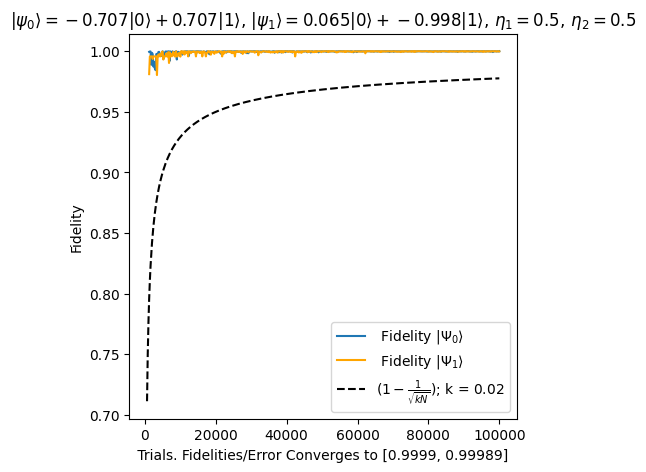

In [ ]:
# 3.75 degrees
Plotting(c= c3point75 ,  N=100000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')
# Plotting(c= c3point75 ,  N=500000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')
Plotting(c= c3point75u,  N=100000,  step= 200, size=[5,5], k = 1/50,  starting_step= 5, input_type = 'theta')

Input state coefficients = [1.0, 0.0, 0.965925826, 0.258819045]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_28089/3238703285.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


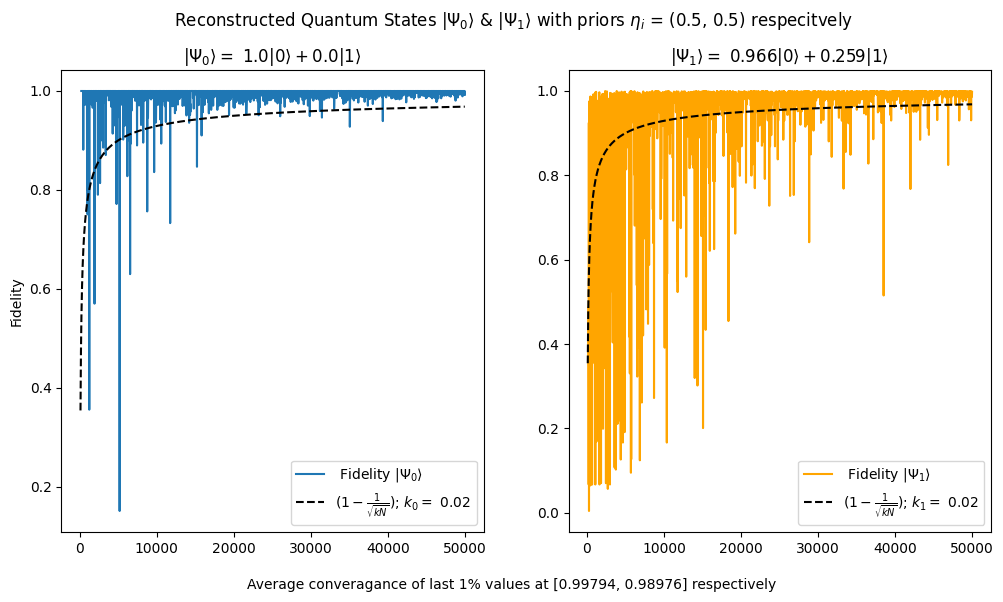

Input state coefficients = [-0.707106781, 0.707106781, 0.258819045, -0.965925826]


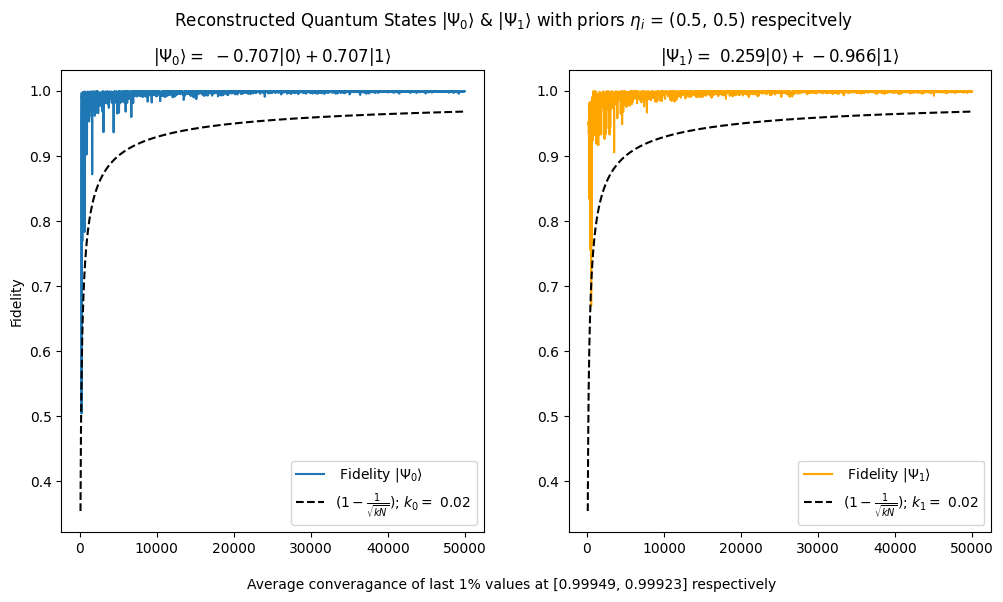

In [ ]:
#trial
Plotting(c= c15 ,  N=50000,  step = 20, k = 1/50, size=[12,6],  starting_step= 10, input_type = 'theta')
Plotting(c= c15u ,  N=50000,  step = 20, k = 1/50, size=[12,6],  starting_step= 10, input_type = 'theta')
# Drastic Differences in graphs even though the Overlap is the same.